In [1]:
import h5py
import numpy as np
%matplotlib inline
import matplotlib.style
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('classic')
from mpl_toolkits.axes_grid1 import make_axes_locatable
import subprocess

from scipy.interpolate import RectBivariateSpline, interp2d
from scipy.ndimage import map_coordinates

In [2]:
py_directory = "../"
py_directory += "output_travelling_vortex/"

def spatially_averaged_rmse(arr,ref):
    n,m = ref.shape
    N = n * m
    return np.sqrt(((arr - ref)**2).mean())

def get_filename(grid_x,grid_y,size,end_time,suffix):
    return "output_travelling_vortex_ensemble=" + str(size) + "_" + str(grid_x) + "_" + str(grid_y) + "_" + str(end_time) + suffix + ".h5"

def get_path(filename):
    return py_directory + filename

def py_out(pyfile,py_dataset,time):
    return pyfile[str(py_dataset)][str(py_dataset)+time][:]

def ensemble_test_case(time, path, N, attribute, label_type='TIME', tag='after_full_step'):
#     inner = (slice(2,-2),slice(2,-2))
    inner = (slice(None,),slice(None,))
    file = h5py.File(path,'r')

    array = []
    for n in range(N):
        if label_type == 'TIME':
#             if N==1:
#                 t_label = '_%.2f_after_full_step' %(time)
#             else:
            t_label = '_ensemble_mem=%i_%.2f_%s' %(n,time, tag)
        elif label_type == 'STEP':
            if N==1:
                t_label = '_%.3d_%s' %(time, tag)
            else:
                t_label = '_ensemble_mem=%i_%.3d_%s' %(n,time, tag)
            
        array.append(py_out(file,attribute,time=t_label)[inner])

    array = np.array(array)
    array = array.mean(axis=0)

    file.close()
    file.close()
    return np.array(array)

def bin_func(obs,ens_mem_shape):
    obs = obs.reshape(ens_mem_shape[0],obs.shape[0]//ens_mem_shape[0],
                      ens_mem_shape[1],obs.shape[1]//ens_mem_shape[1])
    return obs.mean(axis=(1,3))

In [400]:
ref_grid_x = 32
ref_grid_y = 32
grid_x = 32
grid_y = 32
ref_size = 1
ens_size_1 = 10
ens_size_2 = 10
end_time = 6.0
print_output = True
ens_2 = True
# interpolation_method = "map_coordinates"
# interpolation_method = "interp2d"
# mode, order = 'wrap', 3

# inner = (slice(2,-2),slice(2,-2))
# inner = (slice(None,),slice(None,))

# times = np.arange(0,11) / 10
# times= [0.0,0.02,0.04, 0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18,0.20]
# times = [0.0,0.1,0.15,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
# times = np.linspace(0.0,10.0,101)
# times = np.linspace(0.0,10.0,11*2-1)
# times = np.insert(times,1,0.40)
# times = np.linspace(0,1.0,num=21)[::5]
# Ns = 244
# times = np.linspace(0,1.0,num=21)
# times = np.arange(0,174,5)
# times_axis = np.linspace(0,1.0,num=174/5+1)
# times = np.arange(0,Ns)
# times_axis = np.linspace(0,end_time,num=Ns)

times = np.arange(0.0,6.1,0.25)
# times = [0.0]
print(times)

cb1 = [20,20]


attributes = ['rho', 'rhou', 'rhov']
# attributes = ['rho']
# attributes = ['rhoY']
# fn_suffix = "_rho=1.4"

py_filename_ref = get_filename(ref_grid_x, ref_grid_y, ref_size, end_time, "_generated")
py_path_ref = get_path(py_filename_ref)

py_filename_ref_1 = get_filename(grid_x,grid_y,ref_size,end_time, "_comp")
py_path_ref_1 = get_path(py_filename_ref_1)

py_filename_ens_1 = get_filename(grid_x,grid_y,ens_size_1,end_time, "_comp")
py_path_ens_1 = get_path(py_filename_ens_1)
print(py_filename_ens_1)

if ens_2 == True:
    py_filename_ens_2 = get_filename(grid_x,grid_y,ens_size_2,end_time, "_cont_blend_fs=%i_ts=%i" %(cb1[0],cb1[1]))
    py_path_ens_2 = get_path(py_filename_ens_2)


for attribute in attributes:
    rmse_ref_1, rmse_ens_1, rmse_ens_2 = [], [], []
    cnt = 0
    for time in times:
        comp_ref = ensemble_test_case(time, py_path_ref,ref_size, attribute, label_type='TIME')
        # print(comp_ref.shape)
        # comp_ref_inner = comp_ref[inner]
        comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute, label_type='TIME')
        # print(comp_ref_1.shape)
        # comp_ref_1_inner = comp_ref_1[inner]
#         comp_ref = bin_func(comp_ref, comp_ref_1.shape)
        
        # if interpolation_method == "map_coordinates":
        #     x = np.linspace(0,comp_ref_1.shape[0],comp_ref.shape[0])
        #     y = np.linspace(0,comp_ref_1.shape[1],comp_ref.shape[1])

        #     # x = np.linspace(0,comp_ref_1.shape[0]-1,comp_ref.shape[0])
        #     # a = -1
        #     # b = -1
        #     # x = np.arange(comp_ref.shape[0]) / (comp_ref.shape[0] + a) * (comp_ref_1.shape[0] + b)
        #     # y = np.arange(comp_ref.shape[1]) / (comp_ref.shape[1] + a) * (comp_ref_1.shape[1] + b)
        #     # y = np.linspace(0,comp_ref_1.shape[0]-2,comp_ref.shape[1])

        #     x,y = np.meshgrid(x,y)
        #     comp_ref_1 = map_coordinates(comp_ref_1,[y,x],mode=mode,order=order)

        # if interpolation_method == "interp2d":
        #     x = np.linspace(-0.5,0.5,comp_ref_1.shape[0])
        #     y = np.linspace(-0.5,0.5,comp_ref_1.shape[1])

        #     x0 = np.linspace(-0.5,0.5,comp_ref.shape[0])
        #     y0 = np.linspace(-0.5,0.5,comp_ref.shape[1])
        #     mesh = np.array(np.meshgrid(x0,y0))
        #     pts = np.rollaxis(mesh, 0, 3).reshape((-1, 2))
        #     xs_ref = comp_ref.shape[0]
        #     ys_ref = comp_ref.shape[1]
        
        #     comp_ref_1 = interpn((x,y),comp_ref_1,pts, method='linear').reshape(xs_ref,ys_ref).T

        # interpol_ref_1 = RectBivariateSpline(np.linspace(-0.5,0.5,48),np.linspace(-0.5,0.5,48),comp_ref_1)
        # x0 = np.linspace(-0.5,0.5,256)
        # y0 = np.linspace(-0.5,0.5,256)
        # comp_ref_1 =False

        comp_ens_1 = ensemble_test_case(time,py_path_ens_1, ens_size_1, attribute, label_type='TIME')

        # interpol_ens_1 = RectBivariateSpline(np.linspace(-0.5,0.5,48),np.linspace(-0.5,0.5,48),comp_ens_1)
        # x0 = np.linspace(-0.5,0.5,comp_ref.shape[0])
        # y0 = np.linspace(-0.5,0.5,comp_ref.shape[1])
        # comp_ens_1 = interpol_ens_1(x0,y0)

        # if interpolation_method == "map_coordinates":
        #     comp_ens_1 = map_coordinates(comp_ens_1,[y,x],mode=mode,order=order)
        #     # comp_ens_1 = comp_ens_1[inner]
        # if interpolation_method == "interp2d":
        #     comp_ens_1 = interpn((x,y),comp_ens_1,pts, method='linear').reshape(xs_ref,ys_ref).T

        # comp_ref = comp_ref[inner]
        # comp_ref_1 = comp_ref_1[inner]   
        # comp_ens_1 = comp_ens_1[inner]

        rmse_ref_1.append(spatially_averaged_rmse(comp_ref_1,comp_ref))
        rmse_ens_1.append(spatially_averaged_rmse(comp_ens_1,comp_ref))

        if ens_2 == True:
            comp_ens_2 = ensemble_test_case(time, py_path_ens_2, ens_size_2, attribute)
            # if interpolation_method == "map_coordinates":
            #     comp_ens_2 = map_coordinates(comp_ens_2,[y,x],mode=mode,order=order)
                
            # if interpolation_method == "interp2d":
            #     comp_ens_2 = interpn((x,y),comp_ens_2,pts, method='linear').reshape(xs_ref,ys_ref).T

            # comp_ens_2 = comp_ens_2[inner]
            rmse_ens_2.append(spatially_averaged_rmse(comp_ens_2,comp_ref))

        if len(attributes) == 1 and print_output == True:
            nocol = 4 if ens_2 == True else 3
            fig, ax = plt.subplots(ncols=nocol, figsize=(12,5))

            img = ax[0].imshow(comp_ref, origin='lower')
            ax[0].set_title("truth: (%ix%i)" %(ref_grid_x,ref_grid_y))
            img = ax[1].imshow(comp_ref_1, origin='lower')
#             ax[1].set_title("ref: (%ix%i)" %(grid_x, grid_y))
            ax[1].set_title("single run, NO DA")
            img = ax[2].imshow(comp_ens_1, origin='lower')
            ax[2].set_title("DA: ens.=%i" %ens_size_1)
            ax[2].set_title("ens. DA (linear)")
            if ens_2 == True:
                img = ax[3].imshow(comp_ens_2, origin='lower')
                ax[3].set_title("ens. DA (1.0+linear)")
#                 ax[3].set_title("DA: ens.=%i" %ens_size_2)
            fig.colorbar(img, ax=ax, shrink=.5)
            fig.suptitle("time=%.2fs, measurement=%s, ensemble size = 10" %(time,attribute), y=0.8)
            plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
            plt.show()
            
#         print(comp_ref)

        cnt += 1

    plt.figure(figsize=(8,5))
    plt.plot(times,rmse_ref_1, '-*',label='ref. ' + str(grid_x) + 'x' + str(grid_y) + ' sol')
    plt.plot(times,rmse_ens_1, '-*',label='ens. with DA (LETKF), interval = 0.25')
    # plt.plot(times,rmse_ens_1, '-*',label='ens. w/o DA, int=0.10')
    if ens_2 == True:
        plt.plot(times,rmse_ens_2, '-*',label='ens. with DA (LETKF), interval = 1.00')
#         plt.plot(times,rmse_ens_2, '-*',label='ens. with NO DA')
    plt.title("Measurement = %s, ensemble size = %i" %(attribute,ens_size_1))
    plt.xlabel("time")
    plt.ylabel("spatially (and ensemble) averaged RMSE")
    plt.legend(loc='best')
    plt.xticks(times, rotation=45)
    plt.grid()
    plt.savefig("../rmse_" + attribute + fn_suffix + '.png', bbox_inches='tight')
    plt.show()

file = h5py.File(py_directory + py_filename_ens_1, 'r')
if file.__bool__():
    file.close()
if ens_2 == True:
    file = h5py.File(py_directory + py_filename_ens_2, 'r')
    if file.__bool__():
        file.close()

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.  ]
output_travelling_vortex_ensemble=10_32_32_6.0_comp.h5


KeyError: "Unable to open object (object 'rho_ensemble_mem=0_0.00_after_full_step' doesn't exist)"

# Truth generator
## A travelling vortex translator

In [3]:
attribute = 'rho'
time = 0
# comp_ref_0 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute,label_type='STEP')
# time = 0.25
# comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute)

size = 1
grid_x = 64
grid_y = 64
end_time = 1.0
ref_size = size
# suffix = '_truth'
suffix = '_truthgen'

fn = get_filename(grid_x,grid_y,size,end_time,suffix)
print(fn)

path = get_path(fn)
print(path)

fn = get_filename(grid_x,grid_y,size,end_time,'_truth')
py_path_ref_1 = get_path(fn)

file = h5py.File(path, 'a')
attributes = ['rho', 'rhou', 'rhov', 'rhoY', 'Y', 'p2_nodes']
for attr in attributes:
    if not (attr in file):
        file.create_group(attr,track_order=True)
    
file.close()

def roller(arr,n):
    arr = np.roll(arr,n,axis=0)
    arr = np.roll(arr,n,axis=1)
    return arr

# times = np.linspace(0.0,10.0,101*2-1)
# print(times)
times = [0.0,0.25,0.50,0.75,1.0]
steps = range(len(times))
# steps = np.arange(0,321)
# # times = steps / 32
# dt = 1.0 / 32
# times = dt * steps
# print(times)
# print(times)
# print(py_path_ref_1)

# rolled_0 = comp_ref_0.copy()
# rolled_1 = comp_ref_0.copy()

file = h5py.File(path, 'r+')
cnt = 0

output_solver = False
print_output = False

# print(py_path_ref_1)
for n in steps:
    time = times[cnt]
    name = "ensemble_mem=%i_%.2f_%s" %(0,time,'after_full_step')
#     print(name)
    for attribute in attributes: 
        comp_ref_0 = ensemble_test_case(0, py_path_ref_1,ref_size, attribute,label_type='STEP')
        rolled_0 = roller(comp_ref_0,n)[2:-2,2:-2]
        rolled_0 = np.pad(rolled_0,2,mode='wrap')
        
        if output_solver == True:
            comp_ref_1 = ensemble_test_case(time, py_path_ref_1,ref_size, attribute)
        file.create_dataset("%s/%s_%s" %(attribute,attribute,name), data=rolled_0, chunks=True, compression='gzip', compression_opts=4, dtype=np.float32)
    
# rolled = np.pad(rolled,2,mode='wrap')
        if print_output == True and attribute == 'rho':
            if output_solver == True:
                fig, ax = plt.subplots(ncols=3, figsize=(9,3))

                ax[0].imshow(comp_ref_1, origin='lower')
                ax[0].set_title("solver sol.")
                ax[1].imshow(rolled_0[2:-2,2:-2], origin='lower')
                ax[1].set_title("translated sol.")
                im2 = ax[2].imshow(comp_ref_1 - rolled_0[2:-2,2:-2], origin='lower')
                ax[2].set_title("difference")
    #             fig.colorbar(im2,ax=ax[2],shrink=0.4)
                fig.colorbar(im2, ax=ax, shrink=.75)
                fig.suptitle("time=%.2f, measurement=%s" %(time,attribute))
                plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
                plt.show()
            else:
                fig = plt.figure(figsize=(3,3))
                plt.imshow(rolled_0[2:-2,2:-2], origin="lower")
                plt.title("time=%.2f, measurement=%s" %(time,attribute))
                plt.colorbar(shrink=.8)
                plt.show()
                
    cnt += 1
    
file.close()
print("Completed")

output_travelling_vortex_ensemble=1_64_64_1.0_truthgen.h5
../output_travelling_vortex/output_travelling_vortex_ensemble=1_64_64_1.0_truthgen.h5


RuntimeError: Unable to create link (name already exists)

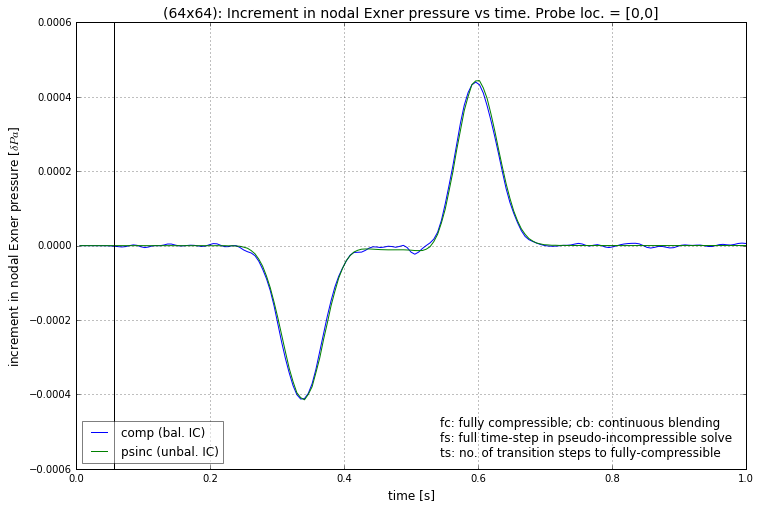

In [365]:
grid_x = 64
grid_y = 64
ens_size = 1
end_time = 1.0
attribute = 'p2_nodes'

time = 1.0
time = 1

def get_arr(time, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    if len(suffix) > 0:
        suffix = '_' + suffix
    
    if cont_blend == True:
        suffix += '_cont_blend_fs=%i_ts=%i' %(fs,ts)

        
    fn = get_filename(grid_x, grid_y, ens_size, end_time, suffix)
    path = get_path(fn)
    
    return ensemble_test_case(time, path, ens_size, attribute, label_type='STEP')

Ns = 176
# times = np.linspace(0,1.0,num=21)
# times = np.arange(0,174,5)
# times_axis = np.linspace(0,1.0,num=174/5+1)
times = np.arange(0,Ns+1)
# times = times[70:120]
# times = times[160:200]
# times = times[10:]
dt = end_time / Ns
# times_axis = np.linspace(0,end_time,num=Ns)
times_axis = times * dt

# times = times[::2]
# times_axis = times_axis[::2]
# print(times_axis)

def get_diff(probe):
    probe = np.array(probe)
    return probe[1:] - probe[:-1]
#     return probe[:-1]


probe_row = 0
probe_col = 0
attribute = 'p2_nodes'
cb1, cb1_suffix = [1,0], ''
cb2, cb2_suffix = [10,0], ''
cb3, cb3_suffix = [1,0], 'nocorrection'

def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    for time in times:
        arr = get_arr(time, attribute, suffix, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr[probe_row,probe_col])
        
    probe = np.array(probe)
    
    return get_diff(probe)
    
probe = get_time_series(times,attribute,"truth")
probe_fc = get_time_series(times,attribute,"comp")
probe_psinc = get_time_series(times,attribute,"psinc")
# probe_psinc = get_time_series(times,attribute,"_psinc_full_corrections")
# probe_psinc = get_time_series(times,attribute,"_psinc_nocorrection")
# probe_cb1 = get_time_series(times,attribute,cb1_suffix,cont_blend=True,fs=cb1[0],ts=cb1[1])
# probe_cb2 = get_time_series(times,attribute,cb2_suffix,cont_blend=True,fs=cb2[0],ts=cb2[1])
# probe_cb3 = get_time_series(times,attribute,cb3_suffix,cont_blend=True,fs=cb3[0],ts=cb3[1])

fig1 = plt.figure(figsize=(12,8))
plt.plot(times_axis[1:],probe, label='comp (bal. IC)')
# plt.plot(times_axis[1:],probe_fc, '--', label='comp (unbal. IC)')
plt.plot(times_axis[1:],probe_psinc, '-', label='psinc (unbal. IC)')
# plt.plot(times_axis[1:],probe_cb1, '-', label='cb: fs=%i, ts=%i' %(cb1[0],cb1[1]))
# plt.plot(times_axis[1:],probe_cb2, '--', label='cb: fs=%i, ts=%i' %(cb2[0],cb2[1]))
# plt.plot(times_axis[1:],probe_cb3, '-', label='cb: fs=%i, ts=%i, %s' %(cb3[0],cb3[1],cb3_suffix))

plt.axvline(times_axis[1:][9], c='k')
# plt.axvline(times_axis[1:][20])
# plt.axvline(3.0)
plt.ylabel('increment in nodal Exner pressure [$\delta Pa$]', fontsize='12')
plt.xlabel('time [s]', fontsize='12')
plt.title("(%ix%i): Increment in nodal Exner pressure vs time. Probe loc. = [%i,%i]" %(grid_x,grid_y,probe_row,probe_col), fontsize='14')
txt = '''
        fc: fully compressible; cb: continuous blending
        fs: full time-step in pseudo-incompressible solve
        ts: no. of transition steps to fully-compressible
        '''
fig1.text(.51,.12,txt,fontsize='12')
plt.xlim([times_axis[0],times_axis[-1]])
plt.legend(loc='lower left', framealpha=0.5)
plt.grid()
plt.show()

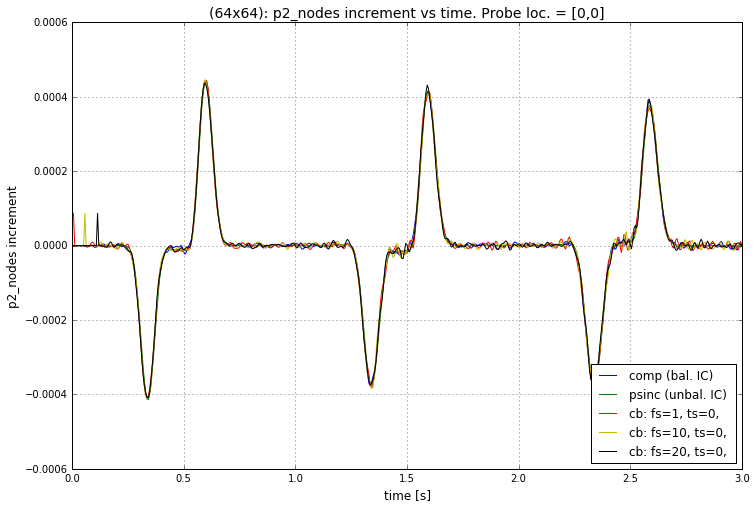

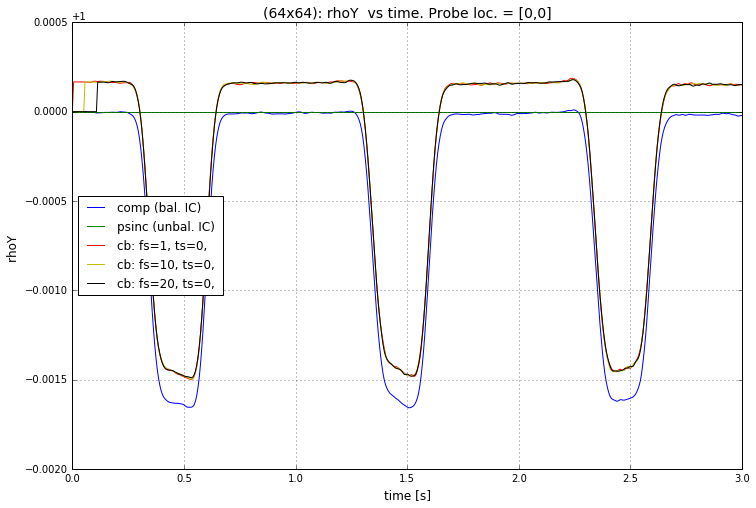

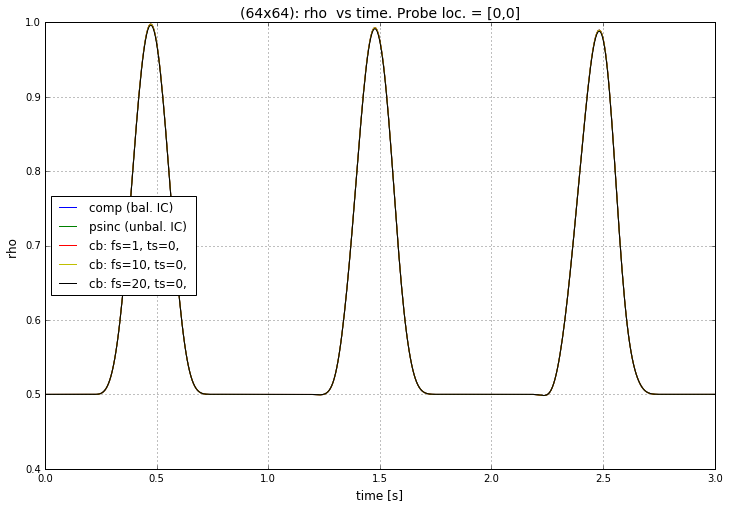

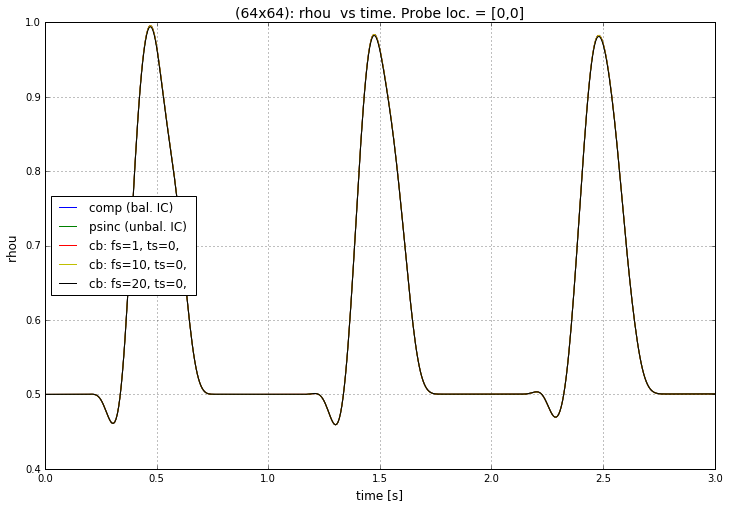

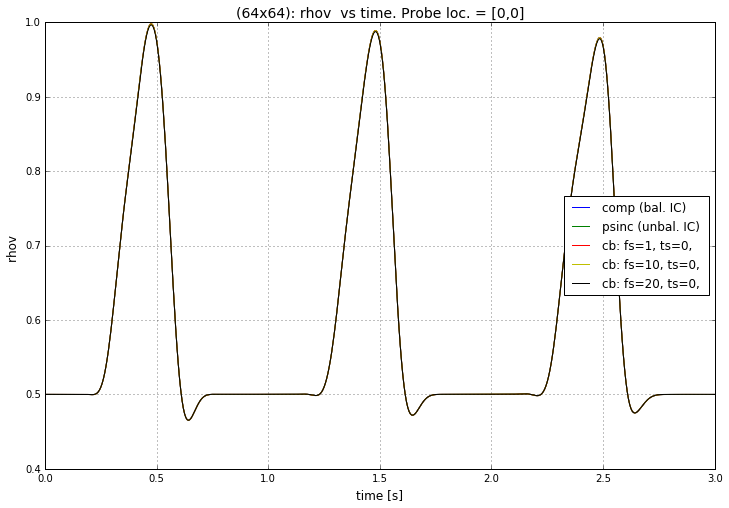

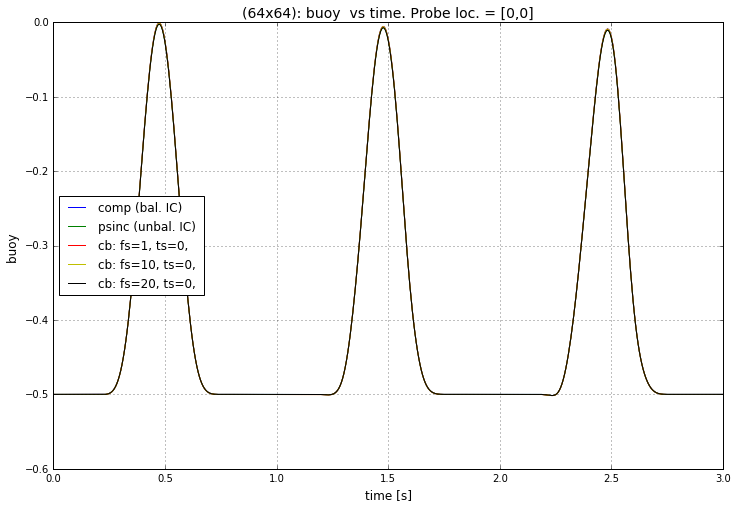

In [25]:
grid_x = 64
grid_y = 64
ens_size = 1
end_time = 3.0
attribute = 'p2_nodes'

time = 1.0
time = 1

def get_arr(time, attribute, suffix, tag, cont_blend=False, ts=0, fs=0, end_time=end_time):
    if cont_blend == True:
        suffix += '_cont_blend_fs=%i_ts=%i' %(fs,ts)
        
    fn = get_filename(grid_x, grid_y, ens_size, end_time, suffix)
    path = get_path(fn)
    
    return ensemble_test_case(time, path, ens_size, attribute, tag=tag, label_type='STEP')

# Ns = 176
# Ns_full = 176
Ns, Ns_full = 528, 528
times = np.arange(0,Ns+1)
# times = times[90:120]
# times = times[-50:]
dt = end_time / Ns_full
times_axis = times * dt

# times_axis = times_axis[::2]
# print(times_axis)

probe_row = 0
probe_col = 0
attributes = ['p2_nodes', 'rhoY', 'rho', 'rhou', 'rhov', 'buoy']
cb1, cb1_suffix = [1,0], ''
cb2, cb2_suffix = [10,0], ''
# cb3, cb3_suffix = [10,0], '_theta_fixed'
cb3, cb3_suffix = [20,0], ''
cb3, cb3_suffix = [10,0], '_theta_fixed'

# cb1, cb1_suffix = [0,5], ''
# cb2, cb2_suffix = [0,10], ''
# cb3, cb3_suffix = [0,20], ''

# cb1, cb1_suffix = [0,5], ''
# cb2, cb2_suffix = [0,10], ''
# cb3, cb3_suffix = [0,20], ''

def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    tag = 'before_flux'
#     tag = 'before_advect'
#     tag = 'after_advect'
#     tag = 'after_ebnaexp'
#     tag = 'after_ebnaimp'
#     
    tag = 'after_half_step'
#     tag = 'after_efna'
#     tag = 'after_full_ebnaexp'
    tag = 'after_full_step'
    
    for time in times:
        arr = get_arr(time, attribute, suffix, tag, cont_blend, ts, fs, end_time=end_time)
        
#         arr -= arr.mean()
        probe.append(arr[probe_row,probe_col])
        
    probe = np.array(probe)
    
    if attribute == 'p2_nodes' and increment == True:
        probe = np.diff(probe)
    return probe
    
# times_axis = np.arange(41)

increment = True
for attribute in attributes:
    if attribute == 'p2_nodes' and increment == True:
        t_axs = times_axis[1:]
        inc = "increment" if increment == True else ""
    else:
        t_axs = times_axis
        inc = ""
        
    probe = get_time_series(times,attribute,"_truth")
#     probe = get_time_series(times,attribute,"_truth_corrected")
    probe_fc = get_time_series(times,attribute,"_comp")
    probe_psinc = get_time_series(times,attribute,"_psinc")
    # probe_psinc = get_time_series(times,attribute,"_psinc_full_corrections")
    # probe_psinc = get_time_series(times,attribute,"_psinc_nocorrection")
    probe_cb1 = get_time_series(times,attribute,cb1_suffix,cont_blend=True,fs=cb1[0],ts=cb1[1])
    probe_cb2 = get_time_series(times,attribute,cb2_suffix,cont_blend=True,fs=cb2[0],ts=cb2[1])
    probe_cb3 = get_time_series(times,attribute,cb3_suffix,cont_blend=True,fs=cb3[0],ts=cb3[1])

    fig1 = plt.figure(figsize=(12,8))
    plt.plot(t_axs,probe, '-', label='comp (bal. IC)', c='b')
#     plt.plot(t_axs,probe_fc, '-', ms=16, label='comp (unbal. IC)', c='b')
    plt.plot(t_axs,probe_psinc, '-', label='psinc (unbal. IC)', c='g')
    plt.plot(t_axs,probe_cb1, '-', label='cb: fs=%i, ts=%i, %s' %(cb1[0],cb1[1], cb1_suffix[1:]), c='r')
    plt.plot(t_axs,probe_cb2, '-', label='cb: fs=%i, ts=%i, %s' %(cb2[0],cb2[1], cb2_suffix[1:]), c='y')
    plt.plot(t_axs,probe_cb3, '-', label='cb: fs=%i, ts=%i, %s' %(cb3[0],cb3[1], cb3_suffix[1:]), c='k')

#     plt.axvline(times_axis[1:][1], c='k')
#     plt.axvline(times_axis[1:][19], c='k')
#     plt.axvline(times_axis[1:][20])
    # plt.axvline(3.0)
    plt.ylabel('%s %s' %(attribute,inc), fontsize='12')
    plt.xlabel('time [s]', fontsize='12')
    plt.title("(%ix%i): %s %s vs time. Probe loc. = [%i,%i]" %(grid_x,grid_y,attribute,inc,probe_row,probe_col), fontsize='14')
#     txt =   '''
#             fc: fully compressible; cb: continuous blending
#             fs: full time-step in pseudo-incompressible solve
#             ts: no. of transition steps to fully-compressible
#             '''
#     fig1.text(.50,.12,txt,fontsize='12')
    plt.xlim([times_axis[0],times_axis[-1]])
    plt.legend(loc='best')
    plt.grid()
    plt.show()

In [9]:
attribute = 'p2_nodes'
times = np.arange(40)
def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    tag = 'ic'
    tag = 'after_full_step'
    probe = []
    for time in times:
        arr = get_arr(time, attribute, suffix, tag, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr)
        
    return np.array(probe)
    
truth = get_time_series(times,attribute,"_truth")
truth_c = get_time_series(times,attribute,"_truth_corrected")
comp = get_time_series(times,attribute,"_comp")
psinc = get_time_series(times,attribute,"_psinc")
cb1_arr = get_time_series(times,attribute,"",cont_blend=True,fs=cb1[0],ts=cb1[1])
cb2_arr = get_time_series(times,attribute,"",cont_blend=True,fs=cb2[0],ts=cb2[1])


sfactor = 1.0
# for i in range(80):
cnt = 0

truth0 = np.copy(truth)
truth = truth[1:] - truth[:-1]
truth_c = truth_c[1:] - truth_c[:-1]
comp0 = np.copy(comp)
comp = comp[1:] - comp[:-1]
psinc0 = np.copy(psinc)
psinc = psinc[1:] - psinc[:-1]
cb1_arr = cb1_arr[1:] - cb1_arr[:-1]
cb2_arr = cb2_arr[1:] - cb2_arr[:-1]
# print(psinc.shape)
# diff = (psinc0[1:] * 0./4 + psinc0[:-1] * 4./4) - comp0[:-1]

# truth1 = truth0[:]-truth0.mean(axis=(1,2))[:,None,None]
# psinc1 = psinc0[:]-psinc0.mean(axis=(1,2))[:,None,None]

# diff = np.diff(psinc0) - np.diff(truth0)
diff = psinc1 - truth1
# diff -= diff.mean()
# diff = np.diff(diff)
# diff1 = (psinc0[1:] * 0.5 + psinc0[:-1] * 0.5) - comp0[:-1]
# diff1 -= diff1.mean()
# diff = psinc0 * 3./4 + comp0 * 1./4 - comp0

for i in range(38,len(times)):
    fig, ax = plt.subplots(nrows=2,ncols=3,figsize=(18,9))
    im0 = ax[0,0].imshow(truth[i], origin="lower")
    ax[0,0].set_title("comp w. bal. IC (p2n increment)")
    fig.colorbar(im0,ax=ax[0,0],shrink=sfactor)
    
    im1 = ax[0,1].imshow(comp[i], origin="lower")
    ax[0,1].set_title("comp w. unbal. IC (p2n icrement)")
    fig.colorbar(im1,ax=ax[0,1],shrink=sfactor)
    
    im2 = ax[0,2].imshow(psinc[i], origin="lower")
    ax[0,2].set_title("psinc w. unbal IC (p2n increment)")
    fig.colorbar(im2,ax=ax[0,2],shrink=sfactor)
    
#     im2a = ax[1,0].imshow(truth_c[i] - psinc[i], origin="lower")
#     ax[1,0].set_title("truth corr - psinc. p2n")
#     fig.colorbar(im2a,ax=ax[1,0],shrink=sfactor)
    
#     im3 = ax[1,1].imshow(cb1_arr[i], origin="lower")
#     ax[1,1].set_title("cb1 p2i,fs/ts=%i/%i" %(cb1[0],cb1[1]))
#     fig.colorbar(im2,ax=ax[1,1],shrink=sfactor)
    
#     im3a = ax[1,2].imshow(cb2_arr[i], origin="lower")
#     ax[1,2].set_title("cb2 p2i,fs/ts=%i/%i" %(cb2[0],cb2[1]))
#     fig.colorbar(im3a,ax=ax[1,2],shrink=sfactor)
    
    im3 = ax[1,0].imshow(truth0[i], origin="lower")
    ax[1,0].set_title("comp w. bal. IC (p2n)")
    fig.colorbar(im3,ax=ax[1,0],shrink=sfactor)

    im4a = ax[1,1].imshow(comp0[i], origin="lower")
    fig.colorbar(im4a,ax=ax[1,1],shrink=sfactor)
    ax[1,1].set_title("comp w. unbal. IC (p2n)")
    
    im4 = ax[1,2].imshow(psinc0[i], origin="lower")
    fig.colorbar(im4,ax=ax[1,2],shrink=sfactor)
    ax[1,2].set_title("psinc w. unbal. IC (p2n)")
    
#     im5 = ax[0,2].imshow(diff[i] , origin="lower")
#     fig.colorbar(im5,ax=ax[0,2],shrink=sfactor)
#     ax[0,2].set_title("Truth PI diff")
    
#     psincm = psinc0[i] - psinc0[i].mean()
#     im6 = ax[1,2].imshow(psincm - psincm.max() , origin="lower")
#     fig.colorbar(im6,ax=ax[1,2],shrink=sfactor)
#     ax[1,2].set_title("diff + psinc")
    
#     fig.delaxes(ax[1,2])
    fig.suptitle(r'Time step=(%.3d-%.3d), time=%.3f for quantity %s' %(i+1,i,times_axis[i],attribute), fontsize='16')

    plt.savefig("../output_images/%s_%03d" %(attribute,cnt), bbox_inches='tight')
    plt.close()
    cnt += 1
#     plt.gca.clear()

NameError: name 'psinc1' is not defined

In [610]:
attribute = 'p2_nodes'
def get_time_series(times, attribute, suffix, cont_blend=False, ts=0, fs=0, end_time=end_time):
    probe = []
    for time in times:
        arr = get_arr(time, attribute, suffix, cont_blend, ts, fs, end_time=end_time)
        probe.append(arr)
        
    return np.array(probe)
    
truth = get_time_series(times,attribute,"_truth")
psinc = get_time_series(times,attribute,"_psinc")
cb_arr = get_time_series(times,attribute,"",cont_blend=True,fs=cb1[0],ts=cb1[1])

# truth = truth[:]-truth.mean(axis=(1,2))[:,None,None]
# psinc = psinc[:]-psinc.mean(axis=(1,2))[:,None,None]
# cb_arr = cb_arr[:]-cb_arr.mean(axis=(1,2))[:,None,None]

# print(psinc_rY[0]-cb_arr_rY[0])
# print((psinc-cb_arr))

attribute = 'rhoY'

truth_rY = get_time_series(times,attribute,"_truth")
psinc_rY = get_time_series(times,attribute,"_psinc")
cb_arr_rY = get_time_series(times,attribute,"",cont_blend=True,fs=cb1[0],ts=cb1[1])

attribute = 'rho'

truth_r = get_time_series(times,attribute,"_truth")
psinc_r = get_time_series(times,attribute,"_psinc")
cb_arr_r = get_time_series(times,attribute,"",cont_blend=True,fs=cb1[0],ts=cb1[1])

attribute = 'rhou'

truth_ru = get_time_series(times,attribute,"_truth")
psinc_ru = get_time_series(times,attribute,"_psinc")
cb_arr_ru = get_time_series(times,attribute,"",cont_blend=True,fs=cb1[0],ts=cb1[1])

attribute = 'rhov'

truth_rv = get_time_series(times,attribute,"_truth")
psinc_rv = get_time_series(times,attribute,"_psinc")
cb_arr_rv = get_time_series(times,attribute,"",cont_blend=True,fs=cb1[0],ts=cb1[1])

sfactor = 1.0

truth_p2i = truth[1:] - truth[:-1]
psinc_p2i = psinc[1:] - psinc[:-1]
cb_arr_p2i = cb_arr[1:] - cb_arr[:-1]

for i in range(8,len(times)-1):
    fig, ax = plt.subplots(nrows=6,ncols=3,figsize=(12,21))
    im0 = ax[0,0].imshow(truth_p2i[i], origin="lower")
    ax[0,0].set_title("truth")
    fig.colorbar(im0,ax=ax[0,0],shrink=sfactor)
    
    im1 = ax[0,1].imshow(psinc_p2i[i], origin="lower")
    ax[0,1].set_title("psinc")
    fig.colorbar(im1,ax=ax[0,1],shrink=sfactor)
    
#     im2 = ax[0,2].imshow(cb_arr_p2i[i], origin="lower")
#     ax[0,2].set_title("cb (fs=%i, ts=%i)" %(cb1[0],cb1[1]))
#     fig.colorbar(im2,ax=ax[0,2],shrink=sfactor)
    
    im3 = ax[1,0].imshow(truth_rY[i], origin="lower")
    ax[1,0].set_title("truth rhoY")
    fig.colorbar(im3,ax=ax[1,0],shrink=sfactor)
    
    im4 = ax[1,1].imshow(psinc_rY[i], origin="lower")
    ax[1,1].set_title("psinc rhoY")
    fig.colorbar(im4,ax=ax[1,1],shrink=sfactor)
    
#     im5 = ax[1,2].imshow(cb_arr_rY[i], origin="lower")
#     ax[1,2].set_title("cb rhoY")
#     fig.colorbar(im5,ax=ax[1,2],shrink=sfactor)
    
    im6 = ax[2,0].imshow(truth[i], origin="lower")
    ax[2,0].set_title("truth p2n")
    fig.colorbar(im6,ax=ax[2,0],shrink=sfactor)
    
    im7 = ax[2,1].imshow(psinc[i], origin="lower")
    ax[2,1].set_title("psinc p2n")
    fig.colorbar(im7,ax=ax[2,1],shrink=sfactor)
    
#     im8 = ax[2,2].imshow(cb_arr[i], origin="lower")
#     ax[2,2].set_title("cb p2n")
#     fig.colorbar(im8,ax=ax[2,2],shrink=sfactor)
    
#     if i+1 == 9:
        
#         dp2n = get_time_series([9],'dp2n_psinc',"",cont_blend=True,fs=cb1[0],ts=cb1[1])
#         dp2c = get_time_series([9],'dp2c_psinc',"",cont_blend=True,fs=cb1[0],ts=cb1[1])
        
#         dp2n[0] -= dp2n[0].mean()
#         dp2c[0] -= dp2c[0].mean()
        
#         im9 = ax[3,0].imshow(dp2n[0], origin="lower")
#         ax[3,0].set_title("Pseudo-Incomp.\n(w. acoustics)")
#         fig.colorbar(im9,ax=ax[3,0],shrink=sfactor)
        
#     im10 = ax[3,1].imshow(dp2c[0], origin="lower")
#     ax[3,1].set_title("Continuous blending \n (fs=%i, ts=%i)" %(cb1[0],cb1[1]))
#     fig.colorbar(im10,ax=ax[3,1],shrink=sfactor)

    im10 = ax[3,1].imshow(truth[i]-cb_arr[i], origin="lower")
    ax[3,1].set_title("Diff: truth-cb, p2n")
    fig.colorbar(im10,ax=ax[3,1],shrink=sfactor)
        
    im11 = ax[3,2].imshow(psinc[i]-cb_arr[i], origin="lower")
    ax[3,2].set_title("Diff: psinc-cb, p2n")
    fig.colorbar(im11,ax=ax[3,2],shrink=sfactor)
    
#     im12 = ax[4,0].imshow(truth_r[i], origin="lower")
#     ax[4,0].set_title("truth rho")
#     fig.colorbar(im12,ax=ax[4,0],shrink=sfactor)
    
#     im13 = ax[4,1].imshow(psinc_r[i], origin="lower")
#     ax[4,1].set_title("psinc rho")
#     fig.colorbar(im13,ax=ax[4,1],shrink=sfactor)
    
#     im14 = ax[4,2].imshow(cb_arr_r[i], origin="lower")
#     ax[4,2].set_title("cb rho")
#     fig.colorbar(im14,ax=ax[4,2],shrink=sfactor)

    im12 = ax[4,0].imshow(truth_r[i] - cb_arr_r[i], origin="lower")
    ax[4,0].set_title("truth - cb rho")
    fig.colorbar(im12,ax=ax[4,0],shrink=sfactor)
    
    im13 = ax[4,1].imshow(psinc_r[i] - cb_arr_r[i], origin="lower")
    ax[4,1].set_title("psinc - cb rho")
    fig.colorbar(im13,ax=ax[4,1],shrink=sfactor)
    
    im14 = ax[4,2].imshow(cb_arr_r[i], origin="lower")
    ax[4,2].set_title("cb rho")
    fig.colorbar(im14,ax=ax[4,2],shrink=sfactor)
    
    im15 = ax[5,0].imshow(cb_arr_rY[i]/cb_arr_r[i], origin="lower")
    ax[5,0].set_title("cb: Y")
    fig.colorbar(im15,ax=ax[5,0],shrink=sfactor)
    
    im16 = ax[5,1].imshow(truth_ru[i]-cb_arr_ru[i], origin="lower")
    ax[5,1].set_title("Diff: truth-cb, rhou")
    fig.colorbar(im16,ax=ax[5,1],shrink=sfactor)
        
    im17 = ax[5,2].imshow(truth_rv[i]-cb_arr_rv[i], origin="lower")
    ax[5,2].set_title("Diff: truth-cb, rhov")
    fig.colorbar(im17,ax=ax[5,2],shrink=sfactor)
    
    fig.suptitle(r'Time step=%.3d, time=%.3f' %(i+1,times_axis[i]), fontsize='16')

    plt.savefig("../output_images/%s_%03d" %(attribute,i), bbox_inches='tight')
    plt.close()
    cnt += 1
    
    print("step=%i, rhoY means: truth=%.6f, psinc=%.6f, cb=%.6f" %(i, truth_rY.mean(),psinc_rY.mean(),cb_arr_rY.mean()))
#     plt.gca.clear()
#     print((truth[i]-psinc[i]).max())
#     print((cb_arr[i] - cb_arr[i-1]).max())
#     print(cb_arr_rY[i]/cb_arr_r[i])

KeyError: "Unable to open object (object 'p2_nodes_017_after_full_step' doesn't exist)"

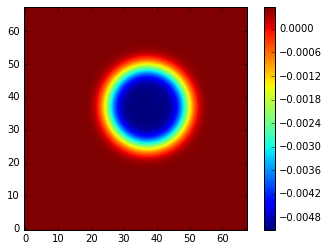

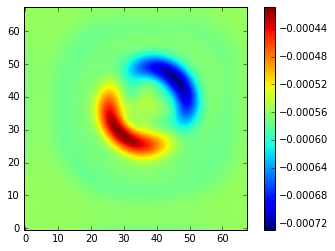

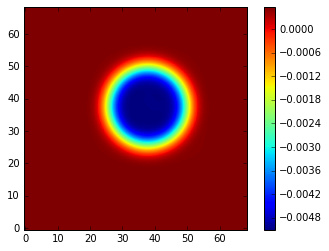

In [34]:
import h5py
from scipy import signal

file = h5py.File("/home/ray/git-projects/RKLM_Reference/output_travelling_vortex/output_travelling_vortex_ensemble=1_64_64_1.0_cont_blend_fs=20_ts=0.h5")
step = '009'
tag = 'after_full_step'
# rhoYn = file['rhoYn']['rhoYn_'+ step +'_'+tag][...]
# rhoYc = file['rhoYc']['rhoYc_'+ step +'_'+tag][...]
# rhoY = file['rhoYcomp']['rhoYcomp_'+ step +'_'+tag][...]
dp2n0 = file['p2_nodes']['p2_nodes_'+ step +'_'+tag][...]
# Yn = file['Yn']['Yn_'+ step +'_'+tag][...]
rhoY = file['rhoY']['rhoY_' + step + '_' + tag][...]
# dp2n = 1.0
file.close()

file = h5py.File("/home/ray/git-projects/RKLM_Reference/output_travelling_vortex/output_travelling_vortex_ensemble=1_64_64_1.0_psinc.h5")
step = '009'
tag = 'after_full_step'
# rhoYn = file['rhoYn']['rhoYn_'+ step +'_'+tag][...]
# rhoYc = file['rhoYc']['rhoYc_'+ step +'_'+tag][...]
# rhoY = file['rhoYcomp']['rhoYcomp_'+ step +'_'+tag][...]
dp2n1 = file['p2_nodes']['p2_nodes_'+ step +'_'+tag][...]
# Yn = file['Yn']['Yn_'+ step +'_'+tag][...]
rhoY = file['rhoY']['rhoY_' + step + '_' + tag][...]
# dp2n = 1.0
file.close()

m0 = dp2n0.mean()
m1 = dp2n1.mean()
m0 = 0.0
m1 = 0.0
a = 0.5
b = 0.5
# dp2n = a*(dp2n0 - m0) + b*(dp2n1 - m1) 
dp2n = dp2n1 - dp2n1.mean()

file = h5py.File("/home/ray/git-projects/RKLM_Reference/output_travelling_vortex/output_travelling_vortex_ensemble=1_64_64_1.0_truth.h5")
step = '009'
tag = 'after_full_step'
# rhoYn = file['rhoYn']['rhoYn_'+ step +'_'+tag][...]
# rhoYc = file['rhoYc']['rhoYc_'+ step +'_'+tag][...]
# rhoY = file['rhoYcomp']['rhoYcomp_'+ step +'_'+tag][...]
dp2ncomp = file['p2_nodes']['p2_nodes_'+ step +'_'+tag][...]
# Yn = file['Yn']['Yn_'+ step +'_'+tag][...]
rhoYc = file['rhoY']['rhoY_' + step + '_' + tag][...]
# dp2n = 1.0
file.close()

p20 = 86220
# print(p20)

msq = 1.159823706796567e-05
# print(p20)
gm1 = 1.4 - 1.
gm1inv = 1./gm1

# print(np.ones(2*[2]))
dp2c = signal.fftconvolve(dp2n, np.ones(dp2n.ndim * [2]), mode='valid')* 0.25
dp2ncc = signal.fftconvolve(dp2ncomp, np.ones(dp2ncomp.ndim * [2]), mode='valid')* 0.25
rel = (rhoY**gm1 - 1.0 + dp2c)
# ret = (rhoY)**gm1/msq - p20
plt.figure()
plt.imshow(rel, origin='lower')
# plt.imshow(dp2n - dp2n.mean(), origin='lower')
plt.colorbar()
plt.show()


plt.figure()
# plt.imshow(rel)
plt.imshow(dp2ncc - rel, origin='lower')
plt.colorbar()
plt.show()

plt.figure()
# plt.imshow(rel)
plt.imshow(dp2ncomp - dp2ncomp.mean(), origin='lower')
plt.colorbar()
plt.show()

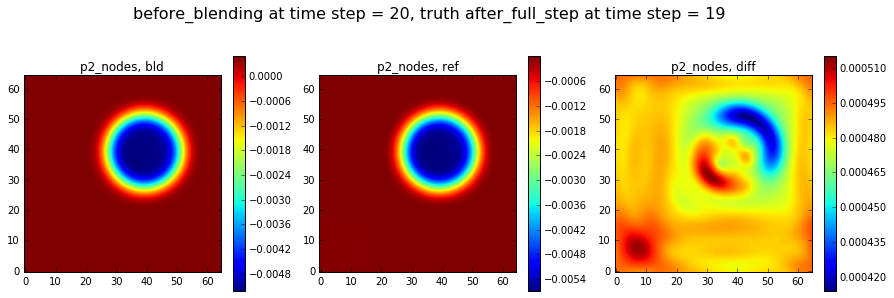

In [250]:
Nx = 64
Ny = 64
N = 1
end_time = 1.0


time = 0.5
times = np.linspace(0.0,1.0,176)
times = [20]
# time = times[20]
# time = 20
attributes = [
#     'rho',
#     'rhou',
#     'rhov',
#     'p2_nodes',
#     'rhoY',
    'p2_nodes'
]

suffix = '_truth'
# suffix = '_psinc'

fn_psinc = get_filename(Nx, Ny, N, end_time, suffix)
path_psinc = get_path(fn_psinc)

fn_bld = get_filename(Nx, Ny, N, end_time, "_cont_blend_fs=20_ts=0")
path_bld = get_path(fn_bld)

tag_bld = 'before_blending'
# tag_bld = 'after_blending'
# tag_bld = 'after_full_step'

tag_psinc = 'after_full_step'
# tag_psinc = ''

for attribute in attributes:
    for time in times:
        time_psinc = time-1
        
        if attribute == 'p2_nodes':
            attribute_bld = 'dp2n'
        else:
            attribute_bld = attribute
            
        arr_bld = ensemble_test_case(time, path_bld, N, attribute_bld, label_type='STEP', tag=tag_bld)
        arr_bld = arr_bld[2:-2,2:-2]
        
#         arr_bld1 = ensemble_test_case(time-1, path_bld, N, attribute_bld, label_type='STEP', tag=tag_bld)
#         arr_bld1 = arr_bld1[2:-2,2:-2]
        
#         arr_bld = ensemble_test_case(time, path_bld, N, 'p2_nodes', label_type='STEP', tag=tag_bld)
#         arr_bld = arr_bld[2:-2,2:-2]

#         arr_bld1 = ensemble_test_case(time+1, path_bld, N, 'p2_nodes', label_type='STEP', tag=tag_bld)
#         arr_bld1 = arr_bld1[2:-2,2:-2]
        
#         arr_bld = 0.5*(arr_bld + arr_bld1)
        
        arr_psinc = ensemble_test_case(time_psinc, path_psinc, N, attribute, label_type='STEP', tag=tag_psinc)
        arr_psinc = arr_psinc[2:-2,2:-2]

#         fig = plt.figure(figsize=(5,6))
        fig, ax = plt.subplots(ncols=3,figsize=(15,6))
        im0 = ax[0].imshow(arr_bld, origin="lower")
        ax[0].set_title("%s, bld" %(attribute))
        fig.colorbar(im0,ax=ax[0],shrink=.7)
        
        im1 = ax[1].imshow(arr_psinc, origin="lower")
        ax[1].set_title("%s, ref" %(attribute))
        fig.colorbar(im1,ax=ax[1],shrink=.7)
        
        im2 = ax[2].imshow(arr_bld - arr_psinc, origin="lower")
        ax[2].set_title("%s, diff" %(attribute))
        fig.colorbar(im2,ax=ax[2],shrink=.7)
        
        plt.suptitle('%s at time step = %i, %s %s at time step = %i' %(tag_bld, time, suffix[1:], tag_psinc, time_psinc), y=.9, fontsize=16)
        plt.show()
        
    print("\n========================================================\n")
    

In [945]:
AA = np.arange(0,1.,0.25)
print(AA)
print(0.25 in AA)
print(AA[np.argwhere(AA==0.25)])

[0.   0.25 0.5  0.75]
True
[[0.25]]
